### Imports

In [1]:
import random
from astropy.io import fits
import os
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import pandas as pd
from torchvision.io import read_image
from torchvision import models
import timm
import cv2 as cv
import torch
import copy
import neptune
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelBinarizer
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from tqdm.autonotebook import tqdm 
import seaborn as sns

plt.rcParams["figure.figsize"] = (5,5)

In [2]:
"""
Collection of functions which enable the evaluation of a classifier's performance,
by showing confusion matrix, accuracy, recall, precision etc.
"""

import numpy as np
import sys

import matplotlib.pyplot as plt

from sklearn import metrics
from tabulate import tabulate
import math
import logging
from datetime import datetime

def read_fits_file(file_name):
    fits_file = fits.open(file_name)
    data = fits_file["PRIMARY"].data
    return data

def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):
    """Plot confusion matrix in a separate window"""
    plt.imshow(ConfMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if label_strings:
        tick_marks = np.arange(len(label_strings))
        plt.xticks(tick_marks, label_strings, rotation=90)
        plt.yticks(tick_marks, label_strings)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row, digits=3, number_of_thieves=2, maxcharlength=35):
    """
    Returns a string of a report for given metric arrays (array length equals the number of classes).
    Called internally by `analyze_classification`.
        digits: number of digits after . for displaying results
        number_of_thieves: number of biggest thieves to report
        maxcharlength: max. number of characters to use when displaying thief names
    """

    relative_freq = support / np.sum(support)  # relative frequencies of each class in the true lables
    sorted_class_indices = np.argsort(relative_freq)[
                            ::-1]  # sort by "importance" of classes (i.e. occurance frequency)

    last_line_heading = 'avg / total'

    width = max(len(cn) for cn in existing_class_names)
    width = max(width, len(last_line_heading), digits)

    headers = ["precision", "recall", "f1-score", "rel. freq.", "abs. freq.", "biggest thieves"]
    fmt = '%% %ds' % width  # first column: class name
    fmt += '  '
    fmt += ' '.join(['% 10s' for _ in headers[:-1]])
    fmt += '|\t % 5s'
    fmt += '\n'

    headers = [""] + headers
    report = fmt % tuple(headers)
    report += '\n'

    for i in sorted_class_indices:
        values = [existing_class_names[i]]
        for v in (precision[i], recall[i], f1[i],
                    relative_freq[i]):  # v is NOT a tuple, just goes through this list 1 el. at a time
            values += ["{0:0.{1}f}".format(v, digits)]
        values += ["{}".format(support[i])]
        thieves = np.argsort(ConfMatrix_normalized_row[i, :])[::-1][
                    :number_of_thieves + 1]  # other class indices "stealing" from class. May still contain self
        thieves = thieves[thieves != i]  # exclude self at this point
        steal_ratio = ConfMatrix_normalized_row[i, thieves]
        thieves_names = [
            existing_class_names[thief][:min(maxcharlength, len(existing_class_names[thief]))] for thief
            in thieves]  # a little inefficient but inconsequential
        string_about_stealing = ""
        for j in range(len(thieves)):
            string_about_stealing += "{0}: {1:.3f},\t".format(thieves_names[j], steal_ratio[j])
        values += [string_about_stealing]

        report += fmt % tuple(values)

    report += '\n' + 100 * '-' + '\n'

    # compute averages/sums
    values = [last_line_heading]
    for v in (np.average(precision, weights=relative_freq),
                np.average(recall, weights=relative_freq),
                np.average(f1, weights=relative_freq)):
        values += ["{0:0.{1}f}".format(v, digits)]
    values += ['{0}'.format(np.sum(relative_freq))]
    values += ['{0}'.format(np.sum(support))]
    values += ['']

    # make last ("Total") line for report
    report += fmt % tuple(values)

    return report


def action_evaluator(y_pred, y_true, class_names, excluded_classes=None, maxcharlength=35, print_report=True, show_plot=True):
    """
    For an array of label predictions and the respective true labels, shows confusion matrix, accuracy, recall, precision etc:
    Input:
        y_pred: 1D array of predicted labels (class indices)
        y_true: 1D array of true labels (class indices)
        class_names: 1D array or list of class names in the order of class indices.
            Could also be integers [0, 1, ..., num_classes-1].
        excluded_classes: list of classes to be excluded from average precision, recall calculation (e.g. OTHER)
    """

    # Trim class_names to include only classes existing in y_pred OR y_true
    in_pred_labels = set(list(y_pred))
    in_true_labels = set(list(y_true))
    # print("predicted labels > ", in_pred_labels, "in_true_labels > ", in_true_labels)

    existing_class_ind = sorted(list(in_pred_labels | in_true_labels))
    # print("pred label", in_pred_labels, "true label", in_true_labels)
    class_strings = [str(name) for name in class_names]  # needed in case `class_names` elements are not strings
    existing_class_names = [class_strings[ind][:min(maxcharlength, len(class_strings[ind]))] for ind in existing_class_ind]  # a little inefficient but inconsequential

    # Confusion matrix
    ConfMatrix = metrics.confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    ConfMatrix_normalized_row = metrics.confusion_matrix(y_true, y_pred, normalize='true') 

    if show_plot:
        plt.figure()
        plot_confusion_matrix(ConfMatrix_normalized_row, label_strings=existing_class_names,
                                title='Confusion matrix normalized by row')
        plt.show(block=False)

    # Analyze results
    total_accuracy = np.trace(ConfMatrix) / len(y_true)
    print('Overall accuracy: {:.3f}\n'.format(total_accuracy))

    # returns metrics for each class, in the same order as existing_class_names
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred, labels=existing_class_ind, zero_division=0)
    # Print report
    if print_report:
        print(generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row))

    # Calculate average precision and recall
    # prec_avg, rec_avg = get_avg_prec_recall(ConfMatrix, existing_class_names, excluded_classes)
    # if excluded_classes:
    #     print(
    #         "\nAverage PRECISION: {:.2f}\n(using class frequencies as weights, excluding classes with no predictions and predictions in '{}')".format(
    #             prec_avg, ', '.join(excluded_classes)))
    #     print(
    #         "\nAverage RECALL (= ACCURACY): {:.2f}\n(using class frequencies as weights, excluding classes in '{}')".format(
    #             rec_avg, ', '.join(excluded_classes)))

    # Make a histogram with the distribution of classes with respect to precision and recall
    # prec_rec_histogram(precision, recall)

    return {"accuracy": total_accuracy, "precision": precision.mean(), "recall": recall.mean(), "f1": f1.mean()}

C:\Users\ACER\AppData\Local\Temp\ipykernel_23144\1186123858.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):


### Configs

In [3]:
ANNO_FILE = "lens_finding/SpaceBasedTraining/classifications_augmented.csv"
IMG_DIR = "lens_finding/SpaceBasedTraining/files"
SAVE_DIR = "E:/GSOC/DeepLense/Test2/model_saves"
os.makedirs(SAVE_DIR, exist_ok=True)

config = {
    "test":"Test2",
    "experiment title":"ViT",
    "train_split":0.8,
    "test_split":0.1,
    "val_split":0.1,
    "enviroment":"local",
    "model":{},
    "n_epochs":25,
    "classifaction_col":"is_lens",
    "device":"gpu",
}

anno_file = pd.read_csv(ANNO_FILE)
true_ids = set(anno_file.loc[anno_file["is_lens"] == 1]["ID"])
false_ids = set(anno_file.loc[anno_file["is_lens"] == 0]["ID"])


X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(anno_file.index, anno_file["is_lens"],
                                                    stratify=anno_file["is_lens"], 
                                                    test_size=config["val_split"]+config["test_split"])

X_val_ind, X_test_ind, y_val_ind, y_test_ind = train_test_split(X_test_ind, y_test_ind,
                                                    stratify=y_test_ind, 
                                                    test_size=config["test_split"]/(config["val_split"]+config["test_split"]))

num_classes = len(np.unique(anno_file[config["classifaction_col"]]))
config["num_classes"] = num_classes
X_train_ind.shape,X_val_ind.shape,X_test_ind.shape,num_classes

((20118,), (2515,), (2515,), 2)

In [6]:
class LensSearchDataset(Dataset):
    def __init__(self, img_dir, annotations,positive_transform=None, negative_transform=None, to_3d=False):
        self.annotations = annotations
        self.img_dir = img_dir
        self.positive_transform = positive_transform
        self.negative_transform = negative_transform
        self.to_3d = to_3d

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/imageEUC_VIS-{self.annotations.iloc[idx, 0]}.fits"
        label = self.annotations.iloc[idx, 1]
        image = read_fits_file(img_path).astype(np.float32)
        if self.to_3d:
            image = cv.cvtColor(image,cv.COLOR_GRAY2RGB)
        else:
            image = np.expand_dims(image, axis=-1)
            
        label = self.annotations.iloc[idx, 1]
        if label==1:
            if self.positive_transform:
                image = self.positive_transform(image)
        else:
            if self.negative_transform:
                image = self.negative_transform(image)
                
        return image, label

In [8]:
stats_arr = np.load("image_stats.npz")

In [23]:
class Normalization2D(object):
    def __init__(self,mean_img,std_img):
        self.mean_img = mean_img
        self.std_img = std_img

    def __call__(self, img):
        img = (img-self.mean_img)/self.std_img
        return img

    def __repr__(self):
        return "Normalization2D"

In [24]:
train_positive_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize(size=(101,101)),
    Normalization2D(mean_img=stats_arr["mean_neg"],std_img=stats_arr["std_neg"]),
    transforms.RandomRotation(75),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip()
    
])

train_negative_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize(size=(101,101)),
    Normalization2D(mean_img=stats_arr["mean_neg"],std_img=stats_arr["std_neg"]),
    #transforms.RandomCrop((101,101),pad_if_needed=True,padding_mode="reflect"),
    #transforms.RandomPerspective(0.2,0.2),
    transforms.RandomRotation(75),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize(size=(101,101)),
    Normalization2D(mean_img=stats_arr["mean_neg"],std_img=stats_arr["std_neg"]),
])

In [25]:
#Dataset definition

train_ds = LensSearchDataset("lens_finding/SpaceBasedTraining/files",
                             anno_file.loc[X_train_ind,:],
                             to_3d=True,
                             positive_transform=train_positive_transform,
                             negative_transform=train_negative_transform
                             )

val_ds = LensSearchDataset("lens_finding/SpaceBasedTraining/files",
                            anno_file.loc[X_val_ind,:],
                            to_3d=True,
                            positive_transform=val_transform,
                            negative_transform=val_transform
                            )

test_ds = LensSearchDataset("lens_finding/SpaceBasedTraining/files",
                            anno_file.loc[X_test_ind,:],
                            to_3d=True,
                            positive_transform=val_transform,
                            negative_transform=val_transform
                            )

In [26]:
# The dataset classes are balanced.

train_ds.annotations[config["classifaction_col"]].value_counts(),val_ds.annotations[config["classifaction_col"]].value_counts()

(1    10059
 0    10059
 Name: is_lens, dtype: int64,
 1    1258
 0    1257
 Name: is_lens, dtype: int64)

In [64]:
#DataLoader definition

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

In [65]:
train_ds[0][0].shape,train_ds[0][1]

(torch.Size([3, 101, 101]), 1)

## Model 

In [89]:
import timm

class DeepLenseModel(nn.Module):
    def __init__(self,num_class,) -> None:
        super(DeepLenseModel,self).__init__()
        self.num_classes = num_class
        self.backbone = timm.create_model("mobilevit_xs",pretrained=True,num_classes=num_class)
        
    def change_final_layer(self,num_classes):
        self.backbone.head.fc = nn.Linear(384,num_classes)
    
    def forward(self,x):
        x = self.backbone(x)
        return x

In [90]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
device

device(type='cuda', index=0)

In [91]:
model = DeepLenseModel(num_class=3)
model.load_state_dict(torch.load("../General Test/model_saves/mobilevit_xs/35.pt")["model_state_dict"])
model.change_final_layer(2)
model

DeepLenseModel(
  (backbone): ByobNet(
    (stem): ConvNormAct(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
    (stages): Sequential(
      (0): Sequential(
        (0): BottleneckBlock(
          (conv1_1x1): ConvNormAct(
            (conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
          )
          (conv2_kxk): ConvNormAct(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (bn): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [92]:
model(torch.rand((32,3,101,101))).size()

torch.Size([32, 2])

In [93]:
model.to(device);

In [94]:
model(torch.rand((32,3,101,101)).to(device)).size()

torch.Size([32, 2])

## Train Configs


In [95]:
loss_modules = {"cross_entropy":nn.CrossEntropyLoss()}
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

## Neptune AI

In [96]:
run = neptune.init_run(
    project="devindesilva/GSOC-DeepLense",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vbmV3LXVpLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9uZXctdWkubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NzI1ZDQyMy05ZTJiLTQ3OGQtYTFiNC05ZGUwMjcyZGM2MzgifQ==",
)

https://new-ui.neptune.ai/devindesilva/GSOC-DeepLense/e/GSOC-34


In [97]:
run["params"] = config

In [98]:
def loss_fn(y_true,y_pred,loss_module,recorder=None):
  categorical_loss = loss_module['cross_entropy'](y_pred,y_true)
  return categorical_loss,{'cross_entropy':categorical_loss}

## Training Loop

In [99]:
def save_model(__model,model_name,unique_name):
    PATH = f"{SAVE_DIR}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":__model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}.pt")
    

def train_step(model, dataloader, optimizer, loss_module, device, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets= batch
            X = X.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output = model(X)

            #loss = cross_entropy_loss
            loss, loss_details = loss_fn(targets,class_output,loss_module)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class using Argmax
            class_output = torch.argmax(class_output, dim=1)
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

def eval_step(model, dataloader, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.eval()
    per_batch = {'targets': [], 'predictions': [], 'metrics': []}
    metrics = {"samples": 0, "loss": 0, "cross_entropy": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets = batch
            X = X.float().to(device)
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output = model(X)
            
            loss, loss_details = loss_fn(targets,class_output,loss_module)

            class_output = torch.argmax(class_output, dim=1)
            pred_action = class_output
                

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['cross_entropy'] += loss_details['cross_entropy']

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets, class_names=class_names, print_report=print_report)
    metrics_dict.update(metrics)
    return metrics_dict

def log(phase, metrics):
    for m, v in metrics.items():
        run[f'{phase}_global/{m}'].log(v)

def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['cross_entropy'] = df['cross_entropy']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    #sns.lineplot(data=df, x='epoch', y='cross_entropy', hue='phase', marker='o', ax=axs[0]).set(title="Cross Entropy. Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")
    

Training Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

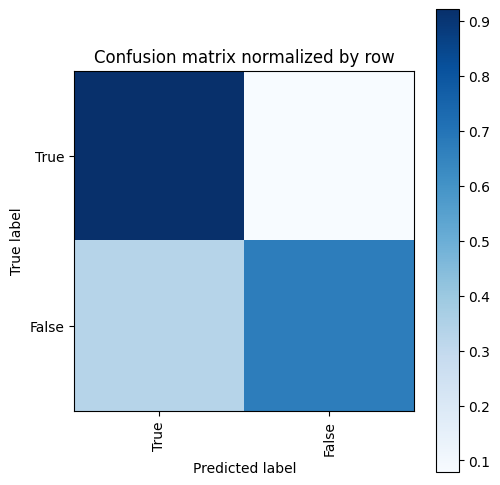

Overall accuracy: 0.796

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.895      0.670      0.766      0.500       1258|	 True: 0.330,	
       True       0.736      0.921      0.818      0.500       1257|	 False: 0.079,	

----------------------------------------------------------------------------------------------------
avg / total       0.816      0.796      0.792        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

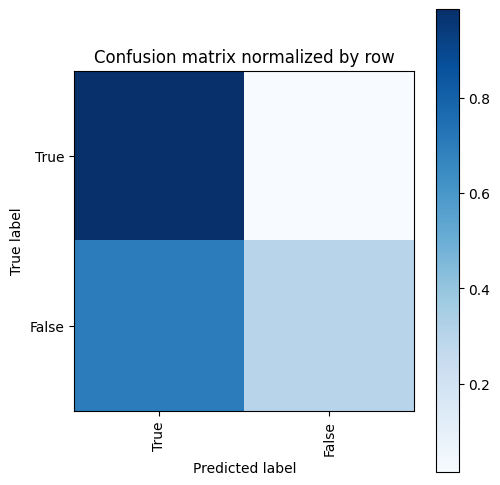

Overall accuracy: 0.643

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.955      0.300      0.457      0.500       1258|	 True: 0.700,	
       True       0.585      0.986      0.734      0.500       1257|	 False: 0.014,	

----------------------------------------------------------------------------------------------------
avg / total       0.770      0.643      0.595        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

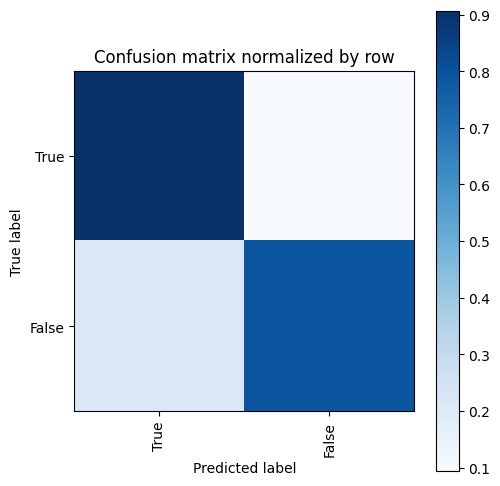

Overall accuracy: 0.847

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.894      0.787      0.837      0.500       1258|	 True: 0.213,	
       True       0.810      0.907      0.856      0.500       1257|	 False: 0.093,	

----------------------------------------------------------------------------------------------------
avg / total       0.852      0.847      0.846        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

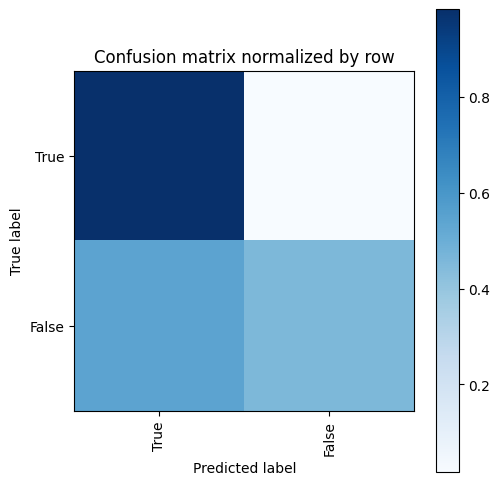

Overall accuracy: 0.719

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.965      0.455      0.619      0.500       1258|	 True: 0.545,	
       True       0.643      0.983      0.778      0.500       1257|	 False: 0.017,	

----------------------------------------------------------------------------------------------------
avg / total       0.804      0.719      0.698        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

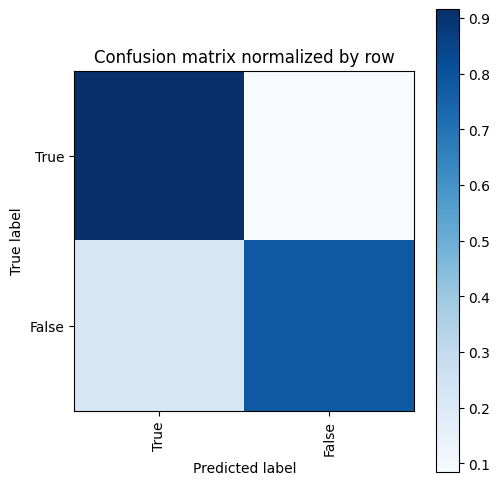

Overall accuracy: 0.850

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.903      0.784      0.839      0.500       1258|	 True: 0.216,	
       True       0.809      0.916      0.859      0.500       1257|	 False: 0.084,	

----------------------------------------------------------------------------------------------------
avg / total       0.856      0.850      0.849        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

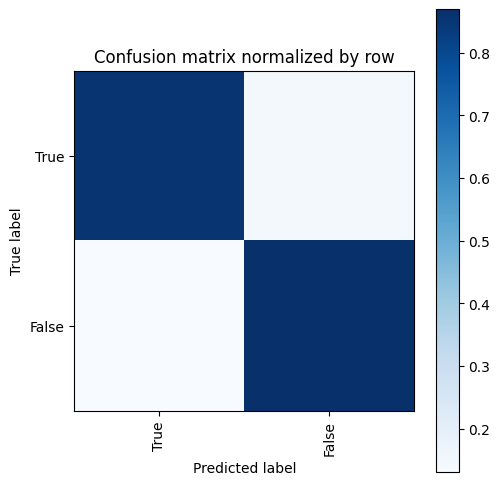

Overall accuracy: 0.862

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.856      0.870      0.863      0.500       1258|	 True: 0.130,	
       True       0.867      0.854      0.860      0.500       1257|	 False: 0.146,	

----------------------------------------------------------------------------------------------------
avg / total       0.862      0.862      0.862        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

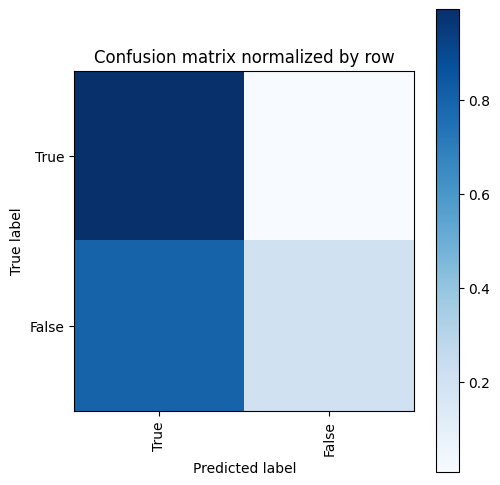

Overall accuracy: 0.597

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.966      0.202      0.334      0.500       1258|	 True: 0.798,	
       True       0.554      0.993      0.711      0.500       1257|	 False: 0.007,	

----------------------------------------------------------------------------------------------------
avg / total       0.760      0.597      0.523        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

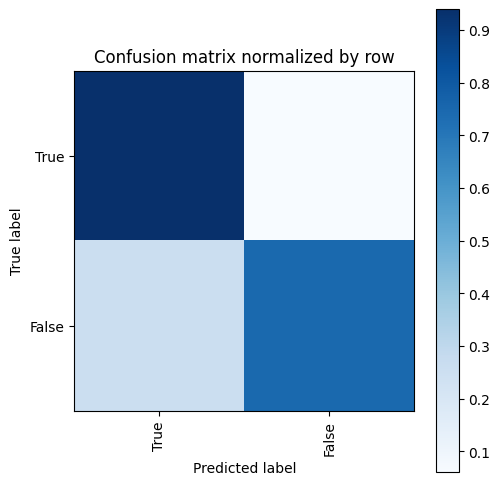

Overall accuracy: 0.843

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.925      0.746      0.826      0.500       1258|	 True: 0.254,	
       True       0.787      0.940      0.856      0.500       1257|	 False: 0.060,	

----------------------------------------------------------------------------------------------------
avg / total       0.856      0.843      0.841        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

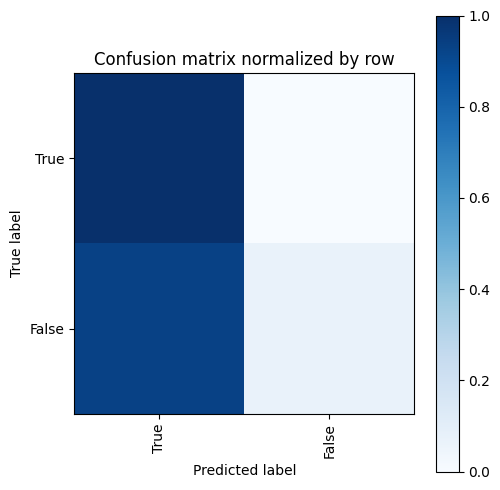

Overall accuracy: 0.534

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       1.000      0.069      0.129      0.500       1258|	 True: 0.931,	
       True       0.518      1.000      0.682      0.500       1257|	 False: 0.000,	

----------------------------------------------------------------------------------------------------
avg / total       0.759      0.534      0.406        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

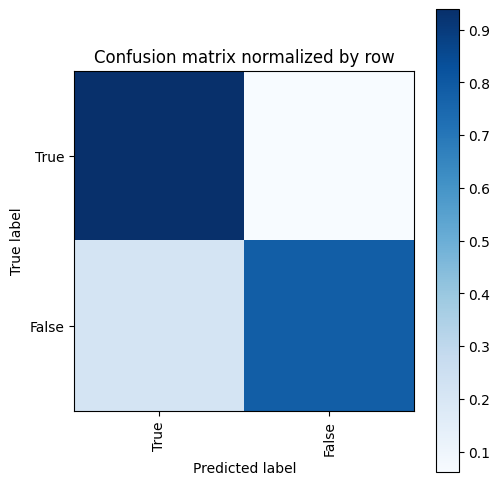

Overall accuracy: 0.861

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.927      0.783      0.849      0.500       1258|	 True: 0.217,	
       True       0.812      0.939      0.871      0.500       1257|	 False: 0.061,	

----------------------------------------------------------------------------------------------------
avg / total       0.870      0.861      0.860        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

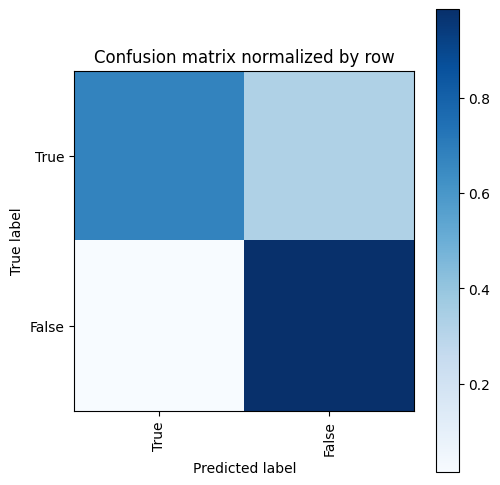

Overall accuracy: 0.829

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.751      0.986      0.853      0.500       1258|	 True: 0.014,	
       True       0.979      0.673      0.798      0.500       1257|	 False: 0.327,	

----------------------------------------------------------------------------------------------------
avg / total       0.865      0.829      0.825        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

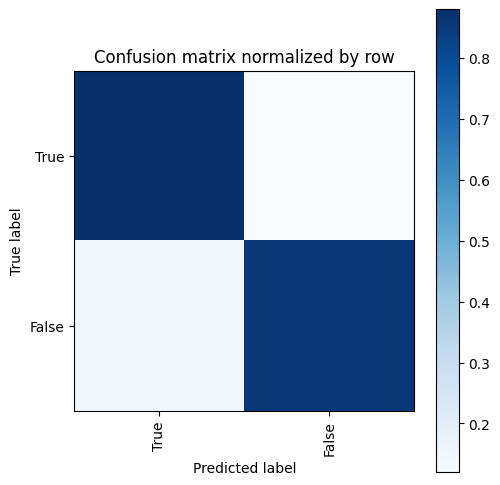

Overall accuracy: 0.867

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.877      0.854      0.865      0.500       1258|	 True: 0.146,	
       True       0.857      0.880      0.868      0.500       1257|	 False: 0.120,	

----------------------------------------------------------------------------------------------------
avg / total       0.867      0.867      0.867        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

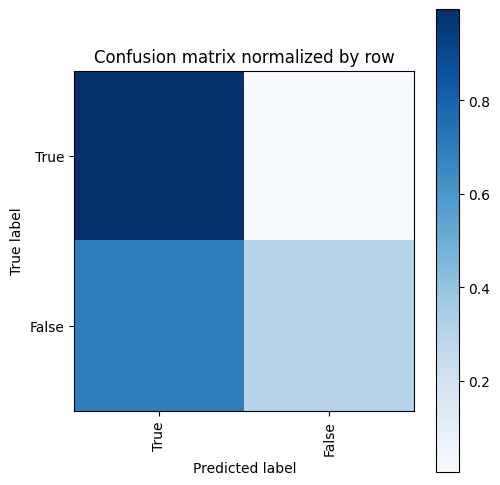

Overall accuracy: 0.650

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.982      0.305      0.466      0.500       1258|	 True: 0.695,	
       True       0.589      0.994      0.739      0.500       1257|	 False: 0.006,	

----------------------------------------------------------------------------------------------------
avg / total       0.785      0.650      0.603        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

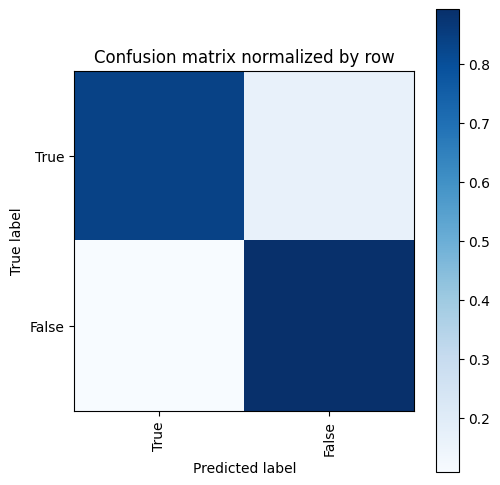

Overall accuracy: 0.864

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.844      0.892      0.867      0.500       1258|	 True: 0.108,	
       True       0.885      0.835      0.860      0.500       1257|	 False: 0.165,	

----------------------------------------------------------------------------------------------------
avg / total       0.865      0.864      0.864        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

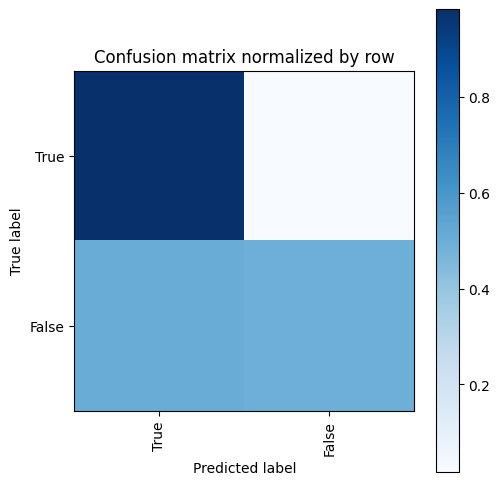

Overall accuracy: 0.738

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.967      0.493      0.653      0.500       1258|	 True: 0.507,	
       True       0.660      0.983      0.790      0.500       1257|	 False: 0.017,	

----------------------------------------------------------------------------------------------------
avg / total       0.813      0.738      0.721        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

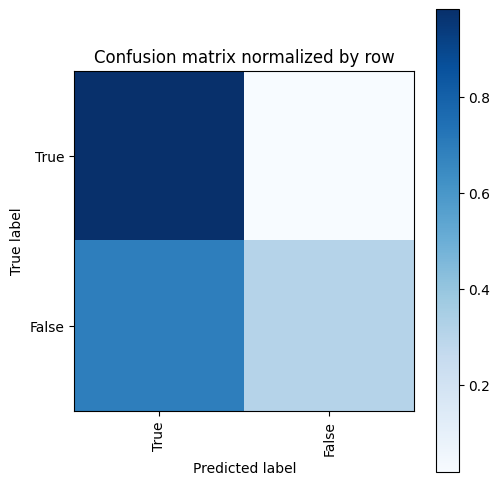

Overall accuracy: 0.646

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.947      0.310      0.467      0.500       1258|	 True: 0.690,	
       True       0.587      0.982      0.735      0.500       1257|	 False: 0.018,	

----------------------------------------------------------------------------------------------------
avg / total       0.767      0.646      0.601        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

Exception in thread NeptuneWebhooks:
Traceback (most recent call last):
  File "e:\GSOC\.venv\lib\site-packages\websocket\_socket.py", line 108, in recv
Exception in thread NeptuneWebhooks:
Traceback (most recent call last):
  File "e:\GSOC\.venv\lib\site-packages\websocket\_socket.py", line 108, in recv
Exception in thread NeptuneWebhooks:
Traceback (most recent call last):
  File "e:\GSOC\.venv\lib\site-packages\websocket\_socket.py", line 108, in recv
    bytes_ = _recv()
  File "e:\GSOC\.venv\lib\site-packages\websocket\_socket.py", line 87, in _recv
    bytes_ = _recv()
  File "e:\GSOC\.venv\lib\site-packages\websocket\_socket.py", line 87, in _recv
    bytes_ = _recv()
  File "e:\GSOC\.venv\lib\site-packages\websocket\_socket.py", line 87, in _recv
    return sock.recv(bufsize)
  File "C:\Python39\lib\ssl.py", line 1226, in recv
    return sock.recv(bufsize)
  File "C:\Python39\lib\ssl.py", line 1226, in recv
    return sock.recv(bufsize)
  File "C:\Python39\lib\ssl.py", line 122

val:   0%|          | 0/79 [00:00<?, ?batch/s]

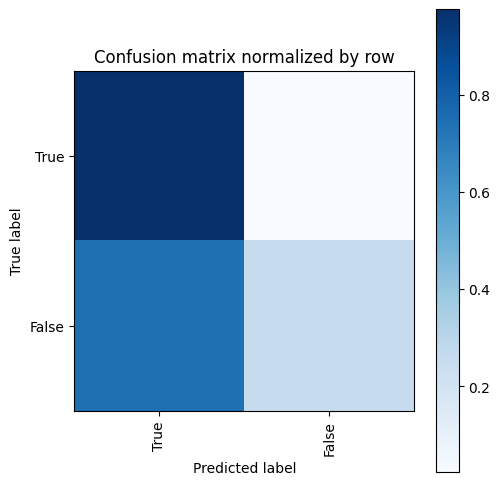

Overall accuracy: 0.616

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.917      0.255      0.399      0.500       1258|	 True: 0.745,	
       True       0.567      0.977      0.718      0.500       1257|	 False: 0.023,	

----------------------------------------------------------------------------------------------------
avg / total       0.742      0.616      0.558        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

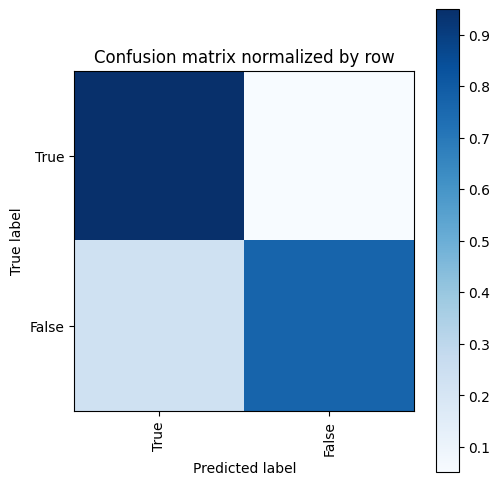

Overall accuracy: 0.859

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.938      0.769      0.845      0.500       1258|	 True: 0.231,	
       True       0.804      0.949      0.871      0.500       1257|	 False: 0.051,	

----------------------------------------------------------------------------------------------------
avg / total       0.871      0.859      0.858        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

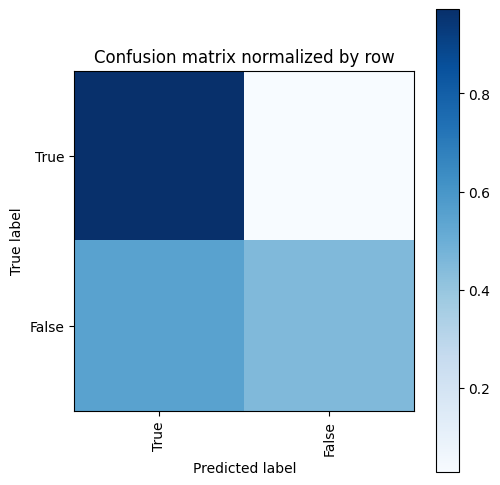

Overall accuracy: 0.711

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.940      0.452      0.610      0.500       1258|	 True: 0.548,	
       True       0.639      0.971      0.771      0.500       1257|	 False: 0.029,	

----------------------------------------------------------------------------------------------------
avg / total       0.790      0.711      0.690        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

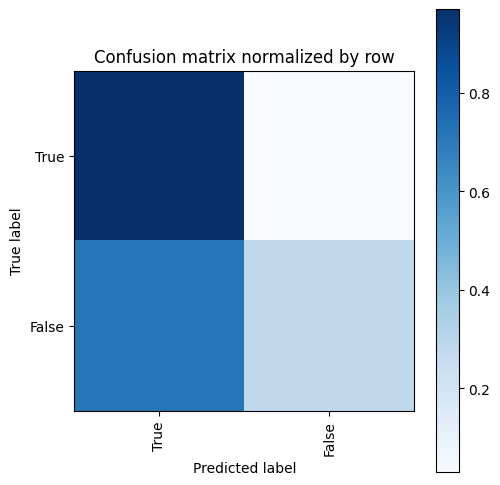

Overall accuracy: 0.627

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.904      0.285      0.433      0.500       1258|	 True: 0.715,	
       True       0.575      0.970      0.722      0.500       1257|	 False: 0.030,	

----------------------------------------------------------------------------------------------------
avg / total       0.740      0.627      0.577        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

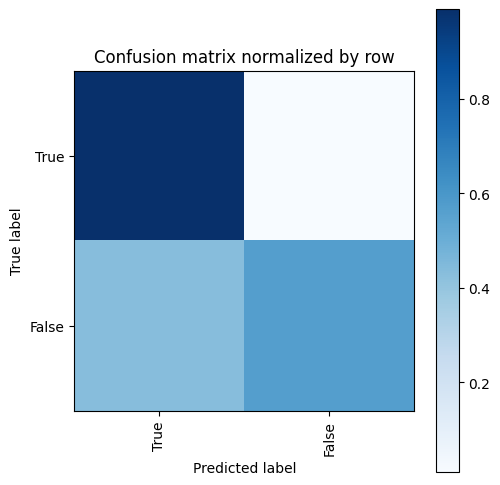

Overall accuracy: 0.778

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.983      0.566      0.718      0.500       1258|	 True: 0.434,	
       True       0.695      0.990      0.817      0.500       1257|	 False: 0.010,	

----------------------------------------------------------------------------------------------------
avg / total       0.839      0.778      0.768        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

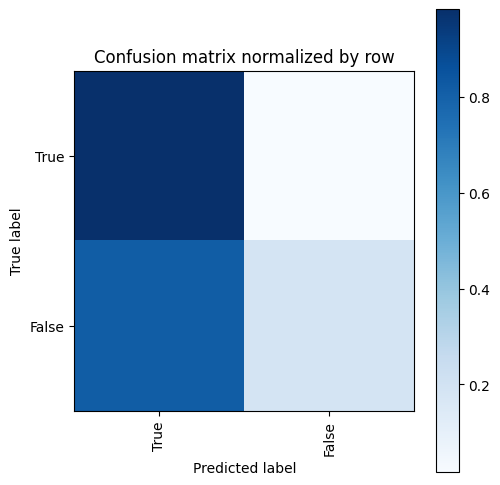

Overall accuracy: 0.584

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.917      0.185      0.308      0.500       1258|	 True: 0.815,	
       True       0.547      0.983      0.703      0.500       1257|	 False: 0.017,	

----------------------------------------------------------------------------------------------------
avg / total       0.732      0.584      0.505        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

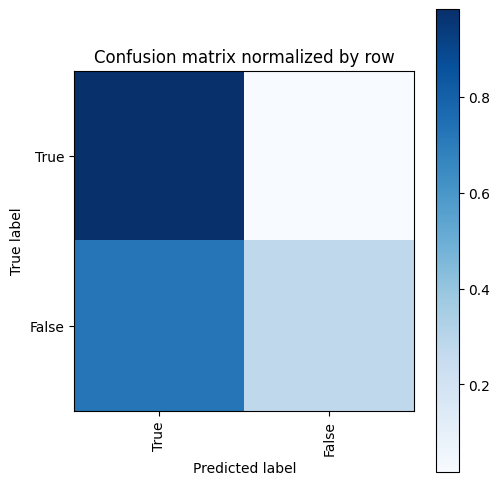

Overall accuracy: 0.631

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.944      0.279      0.431      0.500       1258|	 True: 0.721,	
       True       0.577      0.983      0.727      0.500       1257|	 False: 0.017,	

----------------------------------------------------------------------------------------------------
avg / total       0.760      0.631      0.579        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

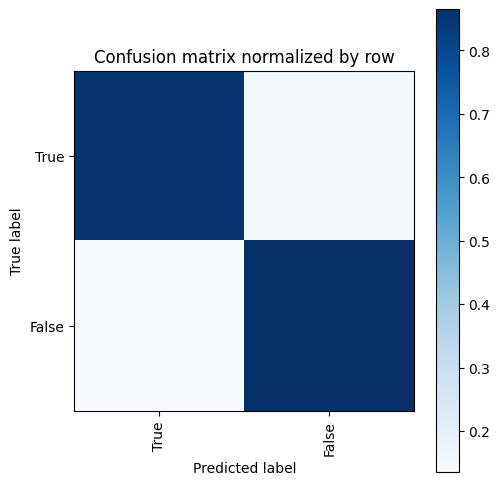

Overall accuracy: 0.859

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.855      0.865      0.860      0.500       1258|	 True: 0.135,	
       True       0.863      0.853      0.858      0.500       1257|	 False: 0.147,	

----------------------------------------------------------------------------------------------------
avg / total       0.859      0.859      0.859        1.0       2515|	      



train:   0%|          | 0/629 [00:00<?, ?batch/s]

val:   0%|          | 0/79 [00:00<?, ?batch/s]

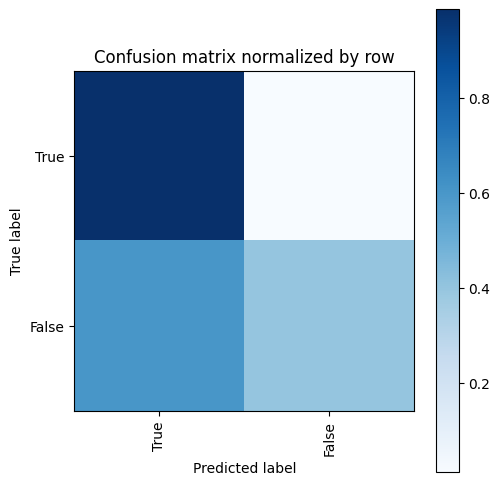

Overall accuracy: 0.693

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

      False       0.969      0.399      0.565      0.500       1258|	 True: 0.601,	
       True       0.621      0.987      0.763      0.500       1257|	 False: 0.013,	

----------------------------------------------------------------------------------------------------
avg / total       0.795      0.693      0.664        1.0       2515|	      



In [100]:
best_acc = 0.0
train_data = []
for epoch in tqdm(range(1,config['n_epochs']+1), desc='Training Epoch',leave=False):

    train_metrics = train_step(model, train_dl, optimizer, loss_modules, device, phase='train', loss_alpha=0.0001)
    train_metrics['epoch'] = epoch
    train_metrics['phase'] = 'train'
    train_data.append(train_metrics)
    log('train', train_metrics)

    eval_metrics = eval_step(model, val_dl, loss_modules, device, class_names=["True","False"], phase='val', loss_alpha=0.0001, print_report=True)
    eval_metrics['epoch'] = epoch 
    eval_metrics['phase'] = 'valid'
    train_data.append(eval_metrics)
    log('valid', train_metrics)
    if eval_metrics['accuracy'] > best_acc:
        best_model = copy.deepcopy(model.state_dict())
        
    if epoch%2 == 0:
        save_model(model,config['experiment title'],epoch)

train_df = pd.DataFrame().from_records(train_data)

In [101]:
train_df

,loss,accuracy,epoch,phase,precision,recall,f1,samples,cross_entropy
0,0.403511,0.772727,1,train,NaN,NaN,NaN,NaN,NaN
1,29.367169,0.795626,1,valid,0.815539,0.795676,0.792369,2515.0,"tensor(29.3672, device='cuda:0')"
2,0.294159,0.909091,2,train,NaN,NaN,NaN,NaN,NaN
3,69.936410,0.642942,2,valid,0.769628,0.643079,0.595539,2515.0,"tensor(69.9364, device='cuda:0')"
4,0.232431,0.954545,3,train,NaN,NaN,NaN,NaN,NaN
5,25.486955,0.846918,3,valid,0.851984,0.846942,0.846372,2515.0,"tensor(25.4870, device='cuda:0')"
6,0.357879,0.818182,4,train,NaN,NaN,NaN,NaN,NaN
7,37.601970,0.719284,4,valid,0.804031,0.719389,0.698319,2515.0,"tensor(37.6020, device='cuda:0')"
8,0.216267,0.954545,5,train,NaN,NaN,NaN,NaN,NaN
9,24.011307,0.849702,5,valid,0.855892,0.849728,0.849052,2515.0,"tensor(24.0113, device='cuda:0')"


<All keys matched successfully>

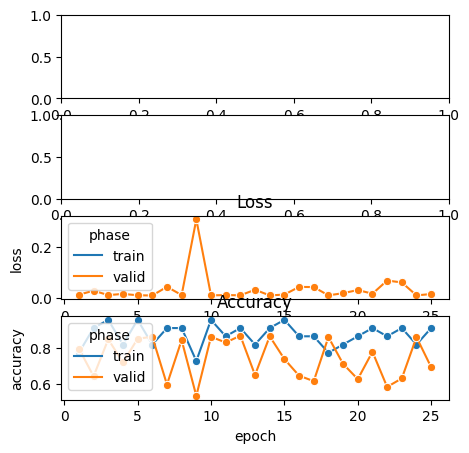

In [102]:
plot_curves(train_df)

model.load_state_dict(best_model)

In [103]:
clsid2clsname = {
    1:"is lens",
    0:"no lens"
}

In [104]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, auc

def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

def micro_auc(preds,targets,probability_scores,id2cls:dict):
    probability_scores = np.apply_along_axis(softmax,1,probability_scores)
    
    micro_roc_auc_ovr = roc_auc_score(
        targets,
        np.argmax(probability_scores,axis=-1),
        multi_class="ovr",
        average="micro",
    )

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")
    
def macro_auc(preds,targets,probability_scores,id2cls:dict):
    lb = LabelBinarizer()
    fpr, tpr, roc_auc = dict(), dict(), dict()
    
    y_onehot_test = lb.fit_transform(targets)
    
    for i in id2cls.keys():
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], probability_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in id2cls.keys():
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= len(id2cls.keys())

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")


def plot_roc_ovr_all(preds,targets,probability_scores,id2cls:dict,fig_size=(14,14)):
    lb = LabelBinarizer()
    
    y_onehot_test = lb.fit_transform(targets)
    y_onehot_pred = lb.transform(preds)
        
    RocCurveDisplay.from_predictions(
        targets,
        np.argmax(probability_scores,axis=-1),
        name="micro-average OvR",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
    plt.legend()
    
    plt.show()
    

def test_metrics(model, dataloader, loss_module, device, class_names,  phase='seen',  print_report=True):
    model = model.eval()
    per_batch = {'targets': [], 'predictions': [], 'metrics': [],"proba_score":[]}
    metrics = {"samples": 0, "loss": 0, "cross_entropy": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets = batch
            X = X.float().to(device)
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output = model(X)
            
            loss, loss_details = loss_fn(targets,class_output,loss_module)
            
            proba_score = class_output
            pred_action = torch.argmax(class_output, dim=1)
                

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['cross_entropy'] += loss_details['cross_entropy']

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch["proba_score"].append(proba_score.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    all_proba_score = np.concatenate(per_batch["proba_score"])
    action_evaluator(y_pred=all_preds, y_true=all_targets, class_names=class_names, print_report=print_report)
    plot_roc_ovr_all(all_preds,all_targets,all_proba_score,clsid2clsname)
    micro_auc(all_preds,all_targets,all_proba_score,clsid2clsname)
    #macro_auc(all_preds,all_targets,all_proba_score,clsid2clsname)
    

In [107]:
model.load_state_dict(torch.load(f"{SAVE_DIR}/{config['experiment title']}/14.pt")["model_state_dict"])

<All keys matched successfully>

### Best model Evaluation

Best Model Evaluation:   0%|          | 0/79 [00:00<?, ?batch/s]

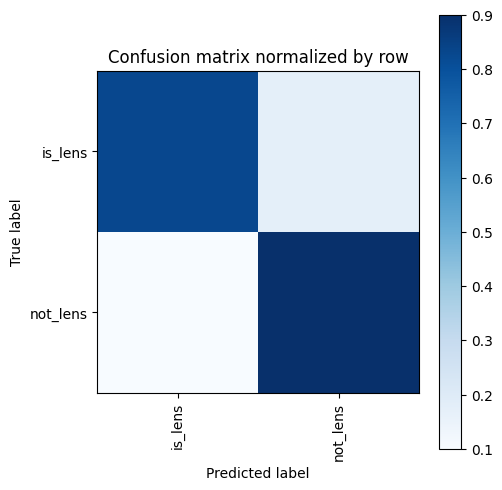

Overall accuracy: 0.864

              precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    is_lens       0.893      0.828      0.859      0.500       1258|	 not_lens: 0.172,	
   not_lens       0.839      0.901      0.869      0.500       1257|	 is_lens: 0.099,	

----------------------------------------------------------------------------------------------------
avg / total       0.866      0.864      0.864        1.0       2515|	      



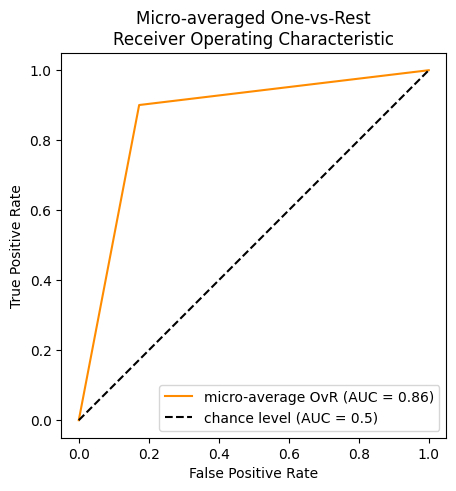

Micro-averaged One-vs-Rest ROC AUC score:
0.86


In [108]:
test_metrics(model, test_dl, loss_modules, device, class_names=["is_lens","not_lens"], phase='Best Model Evaluation', print_report=True)